# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [151]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [152]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 4000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [153]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [154]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1) 
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2) 
    # Вихідний шар
    self.layer_out = DenseLayer(in_features=n_hidden_2, out_features=num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x1 = self.layer_1(x, activation=0)
    x2 = self.layer_2(x1, activation=0)
    x3 = self.layer_out(x2, activation=1)


    return x3

In [155]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Місце для вашого коду
    accuracy_process = tf.metrics.Accuracy()
    accuracy_process.update_state(y_true, tf.argmax(y_pred, axis=1))
    return accuracy_process.result()


In [156]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    variab_opt_list  = neural_net.trainable_variables 
    # Обчислимо за ними значення градієнта
    grgradient  = g.gradient(loss, variab_opt_list )

    # Модифікуємо параметри
    return optimizer.apply_gradients(zip(grgradient,variab_opt_list))

In [157]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)
     
    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        loss_history.append(loss)

        accuracy_process = accuracy(pred, batch_y)
        accuracy_history.append(accuracy_process)
        print(f"Step_number: {step}, Loss: {loss}, Accuracy: {accuracy_process}")


Step_number: 100, Loss: 309.10595703125, Accuracy: 0.68359375
Step_number: 200, Loss: 208.86961364746094, Accuracy: 0.7578125
Step_number: 300, Loss: 95.36380767822266, Accuracy: 0.890625
Step_number: 400, Loss: 152.07357788085938, Accuracy: 0.8203125
Step_number: 500, Loss: 135.08078002929688, Accuracy: 0.83203125
Step_number: 600, Loss: 115.80506896972656, Accuracy: 0.8671875
Step_number: 700, Loss: 103.47091674804688, Accuracy: 0.8828125
Step_number: 800, Loss: 137.75733947753906, Accuracy: 0.8515625
Step_number: 900, Loss: 109.58595275878906, Accuracy: 0.86328125
Step_number: 1000, Loss: 126.49686431884766, Accuracy: 0.85546875
Step_number: 1100, Loss: 110.96297454833984, Accuracy: 0.859375
Step_number: 1200, Loss: 107.11639404296875, Accuracy: 0.859375
Step_number: 1300, Loss: 131.69517517089844, Accuracy: 0.86328125
Step_number: 1400, Loss: 58.518341064453125, Accuracy: 0.9140625
Step_number: 1500, Loss: 69.93377685546875, Accuracy: 0.91015625
Step_number: 1600, Loss: 79.85372924

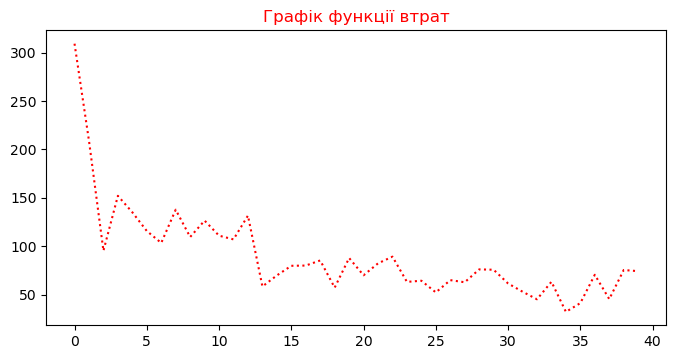

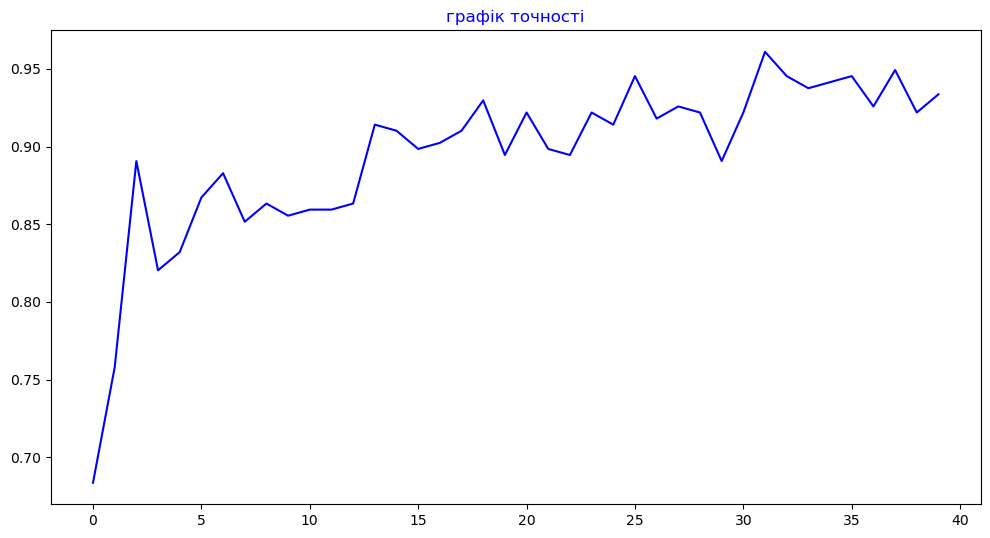

In [158]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.subplots(figsize=(8, 5))
plt.plot(loss_history, "r", linestyle = ':' )
plt.title("Графік функції втрат", color="r")
plt.subplots_adjust(top=0.7)

# Виведіть графік точності
plt.subplots(figsize=(12, 6))
plt.plot(accuracy_history, "b")
plt.title("графік точності", color="b")
plt.subplots_adjust(top=0.9)


In [159]:
# Обчисліть точність навченої нейромережі
accuracy_neural_net = accuracy(neural_net(x_train), y_train)
print(f"Neural Net Accuracy: {accuracy_neural_net}")

Neural Net Accuracy: 0.9306666851043701


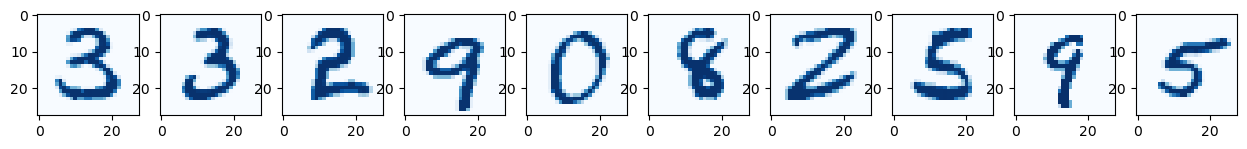

In [160]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.

test_images = np.random.permutation(x_test.shape[0])[:10]
y_test_img = y_test[test_images]
pred_img = [np.argmax(x) for x in neural_net(x_test[test_images])]

for i in range(10):  
  plt.subplot(1, 10, (i + 1))
  plt.imshow(x_test[test_images[i]].reshape(28, 28), cmap="Blues")
  plt.subplots_adjust(right=2)

In [161]:
for i in range(10):
  print(f"Test: {y_test_img[i]}, Predict: {pred_img[i]}")

Test: 3, Predict: 3
Test: 3, Predict: 3
Test: 2, Predict: 2
Test: 9, Predict: 9
Test: 0, Predict: 0
Test: 8, Predict: 8
Test: 2, Predict: 2
Test: 5, Predict: 5
Test: 9, Predict: 9
Test: 5, Predict: 5


 Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Висновки 

Нейромережа працює добре. 

Тестуючи нейромережу декілько разів  бувають випадки помилок,  це відбувається коли цифри намальвані дуже схожі одна на одну. 

Також помилки утворюються, коли береш не всі 10 цифр.